# Figure 6: Disentangling of animal pose parameters by a deep neural network

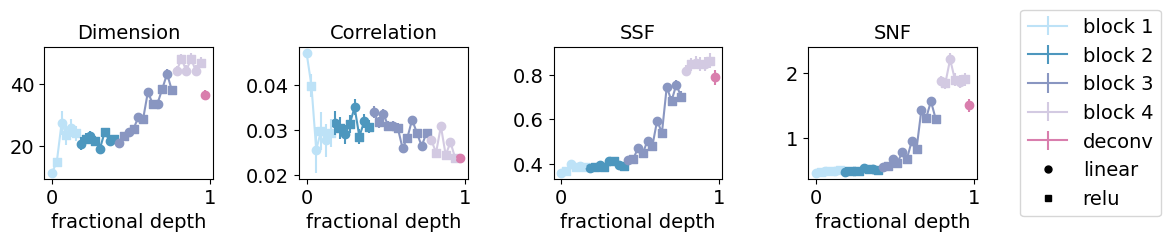

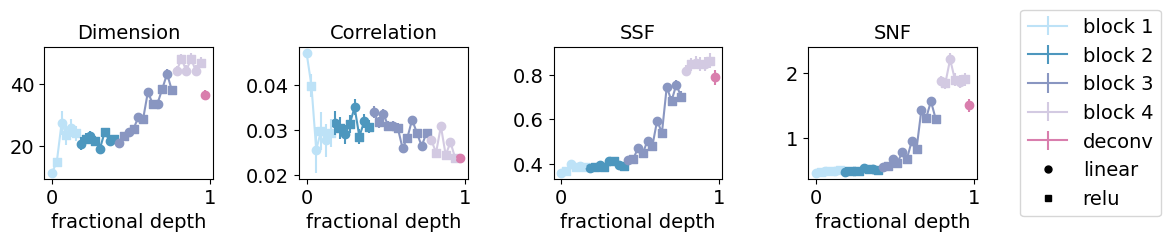

In [14]:
import sys
import os

# !!!
# CHANGE THIS TO WHEREVER YOU CLONED THE REPOSITORY,
# since there is no good way for a notebook to determine
# its own location unfortunately...
# !!!
project_root = "/mnt/home/wslatton/ceph/population_geometry_optimal_coding"

# directory to save figures in
outdir = os.path.join(project_root, "figures", "pngs")

# load DeepLabCut network internal representations

import pickle

# By default, should be the root directory of this repository to use the precomputed representations.
# If you want to retrain a new pose estimation network and extract new representations, use the
# script `code/setup_deeplabcut.py` to set up the environment and train the network, as detailed
# in the README and change this variable to the output directory of that script.
(zs, xs_alls) = pickle.load(open(os.path.join(project_root, "results", "dlc_reps.pkl"), "rb"))
D = zs.shape[1] # dimensionality of latents

sys.path.append(os.path.join(project_root, "code"))

import utils
import matplotlib.pyplot as plt
from matplotlib import lines
import matplotlib as mpl
import numpy as np

def set_size(w,h, ax):
    """ w, h: width, height in inches """
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

def geom_plot(geom_ix, ylabel, legend, ax, fontsize):
    geom_means = []
    geom_sems = []

    for label in xs_alls.keys():
        geom_samples = []

        for i, xs in enumerate(xs_alls[label]):
            data = np.concatenate([zs, xs], axis=1)
            cov = np.cov(data.T)
            geom = utils.get_geometry(cov[D:, D:], cov[D:, :D], cov[:D, :D], 1)
            geom_samples.append(geom[geom_ix])

        geom_means.append(np.mean(geom_samples))
        geom_sems.append(np.std(geom_means) / np.sqrt(len(geom_means)))

    geom_means = np.array(geom_means)
    geom_sems = np.array(geom_sems)
    depth = np.arange(len(geom_means)) / len(geom_means)

    colors = [
        "#BDE2F7", "#4D97BE", "#8996C1", "#D3CAE2", "#D97EAD"
    ]
    names = ["block 1", "block 2", "block 3", "block 4", "deconv"]
    groups = [
        [ix for ix, label in enumerate(xs_alls.keys()) if label.startswith("b1")],
        [ix for ix, label in enumerate(xs_alls.keys()) if label.startswith("b2")],
        [ix for ix, label in enumerate(xs_alls.keys()) if label.startswith("b3")],
        [ix for ix, label in enumerate(xs_alls.keys()) if label.startswith("b4")],
        [ix for ix, label in enumerate(xs_alls.keys()) if label.startswith("pred")]
    ]
    relu_ix = [ix for ix, label in enumerate(xs_alls.keys()) if label.endswith("_relu")]

    for name, color, group in zip(names, colors, groups):
        group_relu = np.intersect1d(relu_ix, group)
        group_linear = np.setdiff1d(group, group_relu)

        ax.errorbar(
            depth[group], geom_means[group], geom_sems[group], color=color, label=name
        )
        ax.scatter(
            depth[group_relu], geom_means[group_relu], color=color, marker="s"
        )
        ax.scatter(
            depth[group_linear], geom_means[group_linear], color=color, marker="o"
        )

    ax.set_xlabel("fractional depth", fontsize=fontsize)
    ax.set_title(ylabel, fontsize=fontsize)

    if legend:
        handles, labels = plt.gca().get_legend_handles_labels()
        custom_line = lines.Line2D([], [], color='k', marker='o', markersize=5, linestyle="none",
                               label='linear')
        handles.append(custom_line)
        custom_line = lines.Line2D([], [], color='k', marker='s', markersize=5, linestyle="none",
                               label='relu')
        handles.append(custom_line)
        ax.legend(handles=handles, bbox_to_anchor=(1.2, 0.5), loc='center left')

fig, axs = plt.subplots(1, 4, figsize=(12, 2.5))
font_size = 14
geom_plot(0, "Dimension", False, axs[0], font_size)
geom_plot(1, "Correlation", False, axs[1], font_size)
geom_plot(3, "SSF", False, axs[2], font_size)
geom_plot(2, "SNF", True, axs[3], font_size)
fig.tight_layout()
fig

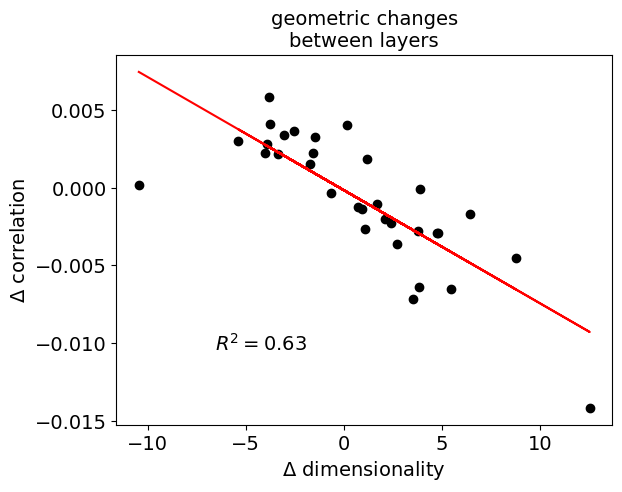

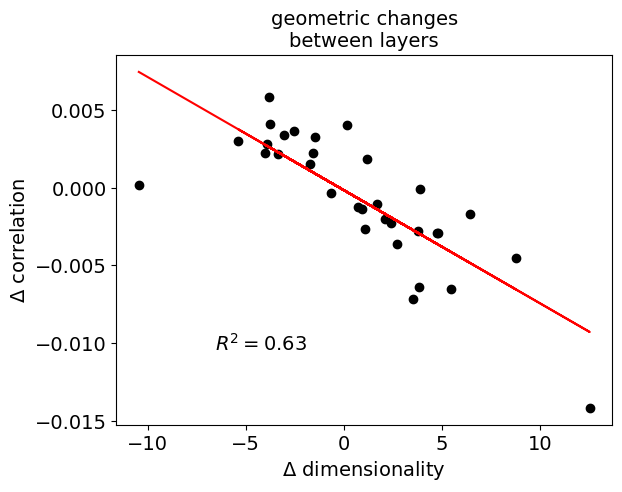

In [16]:
from sklearn.linear_model import LinearRegression as OLS

def tradeoff_plot(ax, fontsize=14):
    dim_means = []
    corr_means = []
    
    for label in xs_alls.keys():
        dim_samples = []
        corr_samples = []
    
        for xs in xs_alls[label]:
            data = np.concatenate([zs, xs], axis=1)
            cov = np.cov(data.T)
            geom = utils.get_geometry(cov[D:, D:], cov[D:, :D], cov[:D, :D], 1)
            dim_samples.append(geom[0])
            corr_samples.append(geom[1])
    
        dim_means.append(np.mean(dim_samples))
        corr_means.append(np.mean(corr_samples))
    
    dim_means = np.array(dim_means)
    corr_means = np.array(corr_means)
    depth = np.arange(len(dim_means)) / len(dim_means)
    
    colors = [
        "#BDE2F7", "#4D97BE", "#8996C1", "#D3CAE2", "#D97EAD"
    ]
    names = ["block 1", "block 2", "block 3", "block 4", "deconv"]
    groups = [
        [ix for ix, label in enumerate(xs_alls.keys()) if label.startswith("b1")],
        [ix for ix, label in enumerate(xs_alls.keys()) if label.startswith("b2")],
        [ix for ix, label in enumerate(xs_alls.keys()) if label.startswith("b3")],
        [ix for ix, label in enumerate(xs_alls.keys()) if label.startswith("b4")],
        [ix for ix, label in enumerate(xs_alls.keys()) if label.startswith("pred")]
    ]
    ax.scatter(np.diff(dim_means), np.diff(corr_means), color="k")
    m = OLS().fit(np.diff(dim_means).reshape(-1, 1), np.diff(corr_means))
    ax.plot(np.diff(dim_means), m.predict(np.diff(dim_means).reshape(-1, 1)), color="r")
    R2 = m.score(np.diff(dim_means).reshape(-1, 1), np.diff(corr_means))
    ax.annotate(f"$R^2 = {R2:.2f}$", (0.2, 0.2), xycoords="axes fraction", fontsize=fontsize)
    ax.set_xlabel("$\Delta$ dimensionality", fontsize=fontsize)
    ax.set_ylabel("$\Delta$ correlation", fontsize=fontsize)
    ax.set_title("geometric changes\nbetween layers", fontsize=fontsize)
    
fig, ax = plt.subplots()
tradeoff_plot(ax)
fig

In [4]:
from tqdm import tqdm

# compute empirical multi-task error for each representation

Ps = [25, 50, 75, 100, 125, 150, 200]
Egs_numerical_all = []

for label, xs_all in tqdm(xs_alls.items()):
    Egs_numerical = []

    for xs in xs_all:
        Egs_numerical.append(
            [utils.emp_error(xs, zs, P, n_task=200)[0] for P in Ps]
        )

    Egs_numerical_all.append(Egs_numerical)

Egs_numerical_all = np.array(Egs_numerical_all)

100%|██████████| 33/33 [00:11<00:00,  2.83it/s]


In [5]:
# compute theoretical multi-task error for each representation

Egs_theory_all = []

for label, xs_all in tqdm(xs_alls.items()):
    Egs_theory = []

    for xs in xs_all:
        data = np.concatenate([zs, xs], axis=1)
        cov = np.cov(data.T)
        Egs_theory.append(
            [utils.theory_part(cov[D:, D:], cov[D:, :D], cov[:D, :D], P) for P in Ps]
        )

    Egs_theory_all.append(Egs_theory)

Egs_theory_all = np.array(Egs_theory_all)

100%|██████████| 33/33 [00:00<00:00, 63.87it/s]


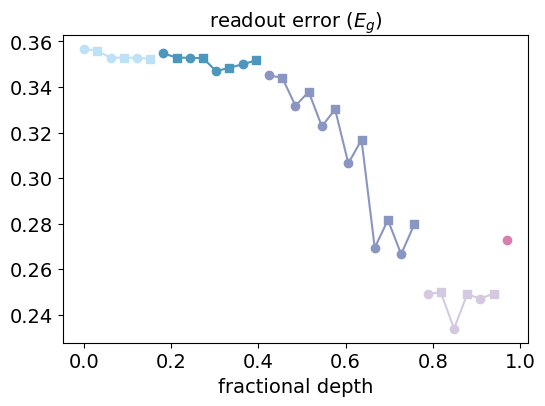

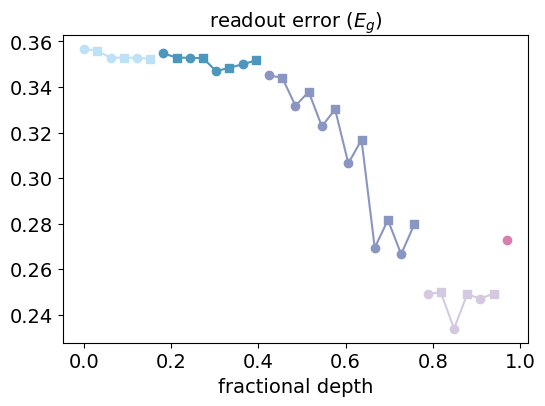

In [17]:
P_ix = len(Ps) - 1
P = Ps[P_ix]
depth = np.arange(Egs_numerical_all.shape[0]) / Egs_numerical_all.shape[0]
Egs_mean_numerical = np.mean(Egs_numerical_all[:, :, P_ix], axis=1)
Egs_sem_numerical = np.std(Egs_numerical_all[:, :, P_ix], axis=1) / np.sqrt(Egs_numerical_all.shape[1])
Egs_mean_theory = np.mean(Egs_theory_all[:, :, P_ix], axis=1)

def plot_Eg_curve(ax, fontsize=14):
    colors = [
        "#BDE2F7", "#4D97BE", "#8996C1", "#D3CAE2", "#D97EAD"
    ]
    names = ["block 1", "block 2", "block 3", "block 4", "deconv"]
    groups = [
        [ix for ix, label in enumerate(xs_alls.keys()) if label.startswith("b1")],
        [ix for ix, label in enumerate(xs_alls.keys()) if label.startswith("b2")],
        [ix for ix, label in enumerate(xs_alls.keys()) if label.startswith("b3")],
        [ix for ix, label in enumerate(xs_alls.keys()) if label.startswith("b4")],
        [ix for ix, label in enumerate(xs_alls.keys()) if label.startswith("pred")]
    ]
    relu_ix = [ix for ix, label in enumerate(xs_alls.keys()) if label.endswith("_relu")]

    for name, color, group in zip(names, colors, groups):
        group_relu = np.intersect1d(relu_ix, group)
        group_linear = np.setdiff1d(group, group_relu)

        #ax.errorbar(
        #    depth[group], Egs_mean_numerical[group], Egs_sem_numerical[group], color=color, label=name
        #)
        #ax.scatter(
        #    depth[group_relu], Egs_mean_numerical[group_relu], color=color, marker="s"
        #)
        #ax.scatter(
        #    depth[group_linear], Egs_mean_numerical[group_linear], color=color, marker="o"
        #)
        ax.plot(
            depth[group], Egs_mean_theory[group], color=color, label=name
        )
        ax.scatter(
            depth[group_relu], Egs_mean_theory[group_relu], color=color, marker="s"
        )
        ax.scatter(
            depth[group_linear], Egs_mean_theory[group_linear], color=color, marker="o"
        )

    ax.set_xlabel("fractional depth", fontsize=fontsize)
    ax.set_title("readout error ($E_g$)", fontsize=fontsize)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plot_Eg_curve(ax)
fig

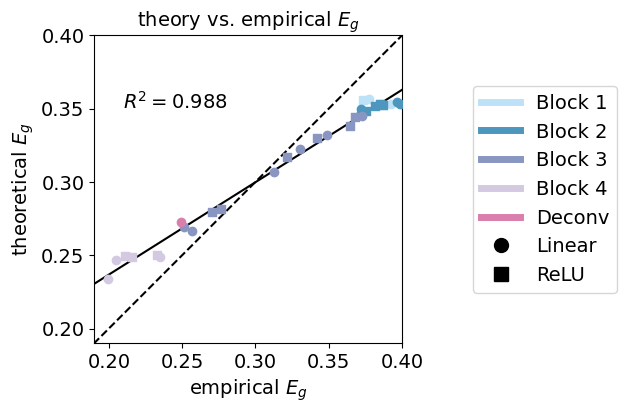

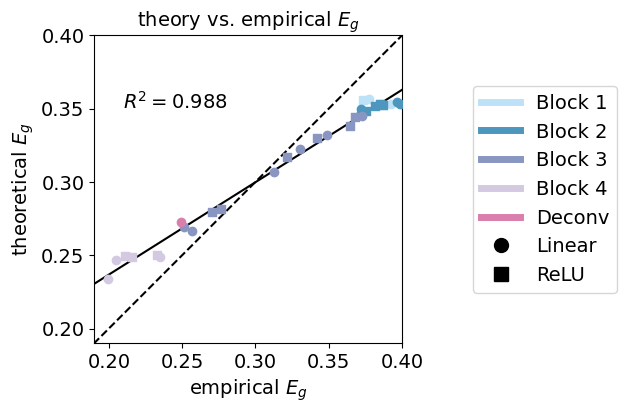

In [18]:
from sklearn.linear_model import LinearRegression as OLS

P_ix = len(Ps) - 1
P = Ps[P_ix]
depth = np.arange(Egs_numerical_all.shape[0]) / Egs_numerical_all.shape[0]
Egs_mean_numerical = np.mean(Egs_numerical_all[:, :, P_ix], axis=1)
Egs_mean_theory = np.mean(Egs_theory_all[:, :, P_ix], axis=1)

def plot_Eg_match(ax, legend, fontsize=14):
    colors = [
        "#BDE2F7", "#4D97BE", "#8996C1", "#D3CAE2", "#D97EAD"
    ]
    names = ["Block 1", "Block 2", "Block 3", "Block 4", "Deconv"]
    groups = [
        [ix for ix, label in enumerate(xs_alls.keys()) if label.startswith("b1")],
        [ix for ix, label in enumerate(xs_alls.keys()) if label.startswith("b2")],
        [ix for ix, label in enumerate(xs_alls.keys()) if label.startswith("b3")],
        [ix for ix, label in enumerate(xs_alls.keys()) if label.startswith("b4")],
        [ix for ix, label in enumerate(xs_alls.keys()) if label.startswith("pred")]
    ]
    relu_ix = [ix for ix, label in enumerate(xs_alls.keys()) if label.endswith("_relu")]

    for name, color, group in zip(names, colors, groups):
        group_relu = np.intersect1d(relu_ix, group)
        group_linear = np.setdiff1d(group, group_relu)

        ax.scatter(
            Egs_mean_numerical[group_relu], Egs_mean_theory[group_relu], color=color, marker="s", zorder=10
        )
        ax.scatter(
            Egs_mean_numerical[group_linear], Egs_mean_theory[group_linear], color=color, marker="o", zorder=10
        )

    ax.plot([0, 0.5], [0, 0.5], color="k", linestyle="--")
    ax.set_xlim([0.19, 0.4])
    ax.set_ylim([0.19, 0.4])
    ax.set_aspect("equal")

    model = OLS().fit(Egs_mean_numerical.reshape(-1, 1), Egs_mean_theory)
    R2 = model.score(Egs_mean_numerical.reshape(-1, 1), Egs_mean_theory)
    ax.plot([0, 1], [model.intercept_, model.intercept_ + model.coef_[0]], "k", zorder=-1)
    ax.set_xlabel("empirical $E_g$", fontsize=fontsize)
    ax.set_ylabel("theoretical $E_g$", fontsize=fontsize)
    ax.set_title("theory vs. empirical $E_g$", fontsize=fontsize)
    ax.annotate(f"$R^2 = {R2:.3f}$", (0.21, 0.35), fontsize=fontsize)

    if legend:
        handles, labels = plt.gca().get_legend_handles_labels()

        for name, color in zip(names, colors):
            custom_line = lines.Line2D([], [], color=color, linestyle="solid", linewidth=5,
                                   label=name)
            handles.append(custom_line)

        custom_line = lines.Line2D([], [], color='k', marker='o', markersize=10, linestyle="none",
                               label='Linear')
        handles.append(custom_line)
        custom_line = lines.Line2D([], [], color='k', marker='s', markersize=10, linestyle="none",
                               label='ReLU')
        handles.append(custom_line)
        ax.legend(handles=handles, bbox_to_anchor=(1.2, 0.5), loc='center left')

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_Eg_match(ax, True)
fig

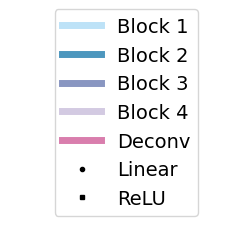

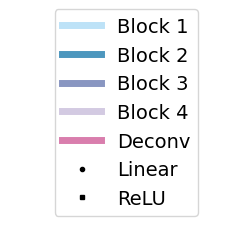

In [25]:
def plot_legend(ax, fontsize=14):
    colors = [
        "#BDE2F7", "#4D97BE", "#8996C1", "#D3CAE2", "#D97EAD"
    ]
    names = ["Block 1", "Block 2", "Block 3", "Block 4", "Deconv"]
    handles, labels = plt.gca().get_legend_handles_labels()

    for name, color in zip(names, colors):
        custom_line = lines.Line2D([], [], color=color, linestyle="solid", linewidth=5,
                               label=name)
        handles.append(custom_line)

    custom_line = lines.Line2D([], [], color='k', marker='o', markersize=3, linestyle="none",
                           label='Linear')
    handles.append(custom_line)
    custom_line = lines.Line2D([], [], color='k', marker='s', markersize=3, linestyle="none",
                           label='ReLU')
    handles.append(custom_line)
    ax.legend(handles=handles, fontsize=fontsize, loc='center')
    ax.axis("off")

fig, ax = plt.subplots(1, 1, figsize=(3, 1))
plot_legend(ax)
fig

## Assembled panels

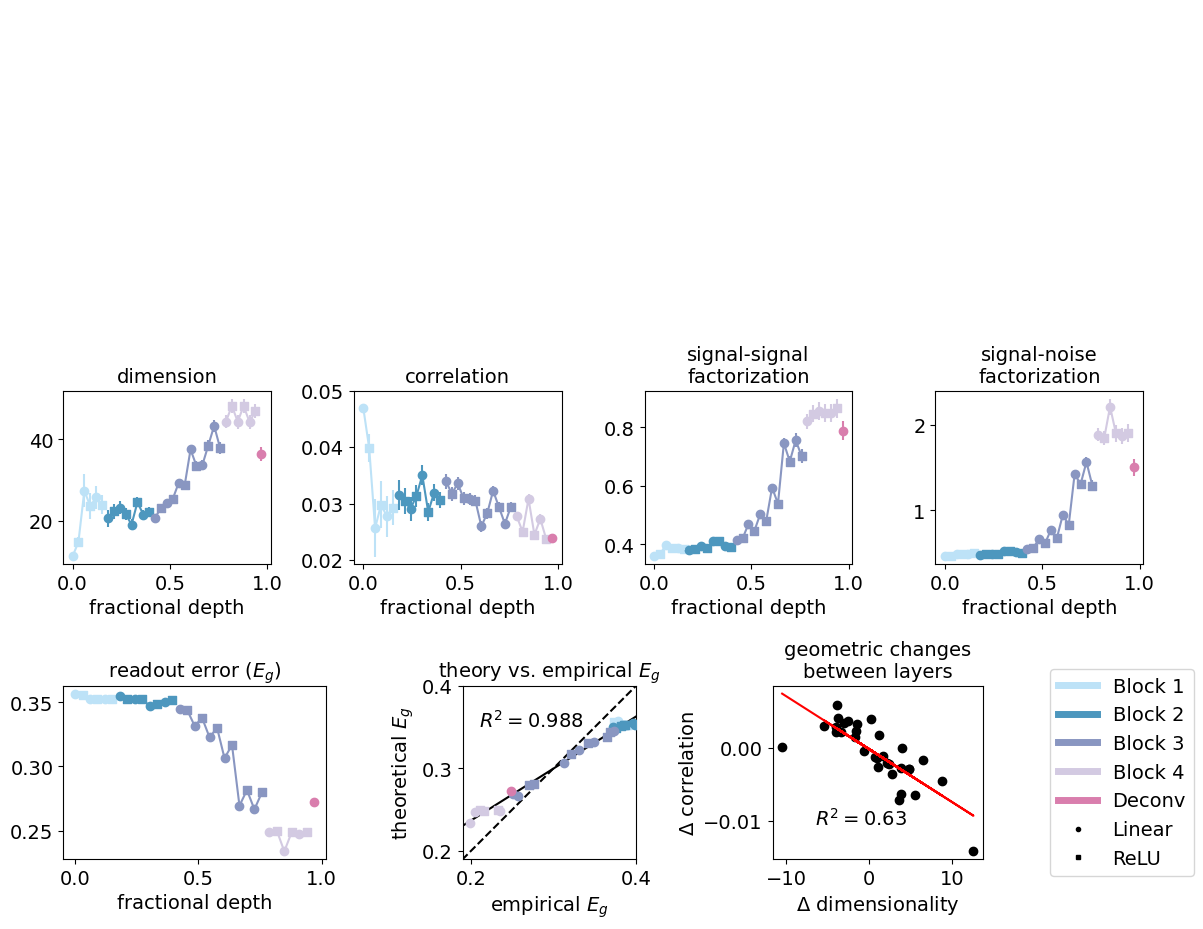

In [26]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["font.size"] = 14
fontsize = 14

# Define relative column widths for the third row
custom_widths_row3 = [1.25, 1.0, 1.0, 0.2]

fig = plt.figure(figsize=(12, 10))

# Top-level grid: 3 rows, 1 column group spanning 4 columns width
gs = GridSpec(
    3, 4,
    figure=fig,
    wspace=0.4, hspace=0.6,
    height_ratios=[1.5, 1, 1],
    left=0.05, right=0.95, top=0.95, bottom=0.1
)

# Row 1: full-width axis
ax_top = fig.add_subplot(gs[0, :])
ax_top.axis("off")

# Row 2: 4 equal-width axes
axes_row2 = [fig.add_subplot(gs[1, i]) for i in range(4)]

# Row 3: nested GridSpec, with its own vertical (and horizontal) spacing
gs_row3 = GridSpecFromSubplotSpec(
    1, 4,
    subplot_spec=gs[2, :],
    width_ratios=custom_widths_row3,
    wspace=0.65
)
axes_row3 = [fig.add_subplot(gs_row3[0, i]) for i in range(4)]

ax_top.axis("off")

geom_plot(0, "dimension", False, axes_row2[0], fontsize)
geom_plot(1, "correlation", False, axes_row2[1], fontsize)
axes_row2[1].set_yticks([0.02, 0.03, 0.04, 0.05])
geom_plot(3, "signal-signal\nfactorization", False, axes_row2[2], fontsize)
axes_row2[2].set_yticks([0.4, 0.6, 0.8])
geom_plot(2, "signal-noise\nfactorization", False, axes_row2[3], fontsize)

plot_Eg_curve(axes_row3[0])
plot_Eg_match(axes_row3[1], False)
tradeoff_plot(axes_row3[2])
plot_legend(axes_row3[3])

fig.savefig(f"{outdir}/f4_deeplabcut.pdf", dpi=300, transparent=True)
fig.show()